In [1]:
# Standard Python Libraries
from difflib import get_close_matches
import warnings

# Standard Data Manipulation & Mathematics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Scikit-Learn: Pipeline & Preprocessing Architecture
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector 
from sklearn.base import BaseEstimator, TransformerMixin

# Imputation Modules
from sklearn.experimental import enable_iterative_imputer  # Must import this before IterativeImputer
from sklearn.impute import SimpleImputer, IterativeImputer # MICE & Simple

from sklearn.preprocessing import RobustScaler, TargetEncoder, FunctionTransformer, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

# Scikit-Learn: Model Selection, Evaluation & Inspection
# Added train_test_split here vvv
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split, cross_validate
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import (
    mean_squared_error, 
    make_scorer, 
    mean_absolute_error, 
    r2_score, 
    mean_absolute_percentage_error
)

# Scikit-Learn: Algorithms (Regressors)
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import RFE

# Statistical Distributions (for Random Search)
from scipy.stats import randint, uniform

In [2]:
#Suppress warnings to maintain a clean execution log during iterative training
warnings.filterwarnings('ignore')

# Configure Pandas display options for easier dataframe inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Define Global Random Seed for Reproducibility
# This ensures that all random operations (splits, initializations) are constant.
RSEED = 42
np.random.seed(RSEED)

In [3]:
# Load the training and testing datasets from the working directory
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Isolate the Target Variable ('price') and Features (X)
# We use the suffix '_full' to indicate this is the complete training set
# prior to any cross-validation splitting.
X_train_full = train_df.drop(columns=['price'])
y_train_full = train_df['price']

#Apply Log-Transformation to Target
# Predicting log(price) stabilizes variance and improves linear model performance.
y_train_log = np.log1p(y_train_full)

In [4]:
class DataCleaner:
    """
    Applies robust, algorithmic cleaning rules to the raw dataset.
    
    PURPOSE:
    To standardize categorical labels, sanitize numeric errors, and properly 
    handle the 'carID' identifier to prevent feature leakage.
    """
    
    def __init__(self):
        """
        Initializes the cleaning agent with 'Golden Source' definitions.
        """
        # 1. GOLDEN SOURCE DEFINITIONS
        self.valid_brands = [
            'audi', 'bmw', 'ford', 'hyundai', 'mercedes', 'opel', 
            'skoda', 'toyota', 'volkswagen'
        ]
        
        self.valid_transmissions = ['manual', 'semi-auto', 'automatic']
        self.valid_fuels = ['petrol', 'diesel', 'hybrid', 'other']
        
        # 2. EXCEPTION: MANUAL MAPPING
        self.model_map = {
             'tigua': 'tiguan', 't-ro': 't-roc', 'tiguan allspac': 'tiguan allspace',
             'astr': 'astra', 'fiest': 'fiesta', 'insigni': 'insignia',
             'octavi': 'octavia', 'monde': 'mondeo', 'passa': 'passat',
             'edg': 'edge', 'mokk': 'mokka', 'arteo': 'arteon',
             'aur': 'auris', 'fabi': 'fabia', 'ayg': 'aygo',
             'gol': 'golf', 'coroll': 'corolla', 'zafir': 'zafira',
             'c-ma': 'c-max', 'grand c-ma': 'grand c-max', 'b-ma': 'b-max',
             'yeti outdoo': 'yeti outdoor', 'grand tourneo connec': 'grand tourneo connect'
        }

    def _fuzzy_correct(self, value, valid_list, cutoff=0.75):
        """
        Internal helper function to apply Algorithmic Correction using Sequence Similarity.
        """
        if pd.isna(value): 
            return value
        if value in valid_list:
            return value
        
        matches = get_close_matches(value, valid_list, n=1, cutoff=cutoff)
        if matches:
            return matches[0]
            
        return 'unknown' 

    def transform(self, df):
        """
        Applies the cleaning logic to the dataframe.
        """
        df = df.copy() 
        
        
        # 1. INDEX HANDLING
        # We move 'carID' to the Index. This removes it from the 'features' list (hiding it from the model) while preserving it for the final submission file.
        if 'carID' in df.columns:
            df = df.set_index('carID')
        
        # 2. String Standardization
        str_cols = ['Brand', 'transmission', 'fuelType', 'model']
        for col in str_cols:
            if col in df.columns:
                df[col] = df[col].str.lower().str.strip()

        # 3. Algorithmic Correction
        if 'Brand' in df.columns:
            df['Brand'] = df['Brand'].apply(lambda x: self._fuzzy_correct(x, self.valid_brands, cutoff=0.7))
            
        if 'transmission' in df.columns:
            df['transmission'] = df['transmission'].apply(lambda x: self._fuzzy_correct(x, self.valid_transmissions, cutoff=0.8))
            
        if 'fuelType' in df.columns:
            df['fuelType'] = df['fuelType'].apply(lambda x: self._fuzzy_correct(x, self.valid_fuels, cutoff=0.8))

        # 4. Manual Correction
        if 'model' in df.columns:
            df['model'] = df['model'].replace(self.model_map)

        # 5. Numeric Sanity Checks
        cols_to_check = ['mileage', 'tax', 'mpg', 'engineSize', 'previousOwners']
        for col in cols_to_check:
            if col in df.columns:
                df[col] = df[col].mask(df[col] < 0, np.nan)

        # 6. Temporal Logic
        if 'year' in df.columns:
            df['year'] = pd.to_numeric(df['year'], errors='coerce').round()
            df.loc[df['year'] > 2020, 'year'] = np.nan
            df['year'] = df['year'].astype('Int64')

        # 7. Discrete Logic
        if 'previousOwners' in df.columns:
            df.loc[df['previousOwners'] % 1 != 0, 'previousOwners'] = np.nan
            df['previousOwners'] = df['previousOwners'].astype('float')
            
        return df

# Execution
# We initialize the class and process both datasets immediately.
# Note: X_train_clean and X_test_clean will now have 'carID' as their Index.
cleaner = DataCleaner()
X_train_clean = cleaner.transform(X_train_full)
X_test_clean = cleaner.transform(test_df)

In [5]:
# 1. Custom Domain Logic Transformer (Class-Based)
class CarFeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Encapsulates domain-specific logic into a Scikit-Learn compatible transformer.
    
    PURPOSE:
    To generate predictive features ('age', 'usage_intensity') and remove 
    redundant or noisy features to streamline the model.
    """
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Robust Type Casting
        for col in ['year', 'mileage', 'engineSize']:
            if col in X.columns:
                X[col] = X[col].astype(float)
            
        # Depreciation feature: Age
        if 'year' in X.columns:
            X['age'] = (2020 - X['year']).clip(lower=0)
            
        # Usage intensity feature: mileage_per_year
        if 'mileage' in X.columns and 'age' in X.columns:
            X['mileage_per_year'] = np.where(
                X['age'] > 0, 
                X['mileage'] / X['age'], 
                X['mileage']
            )
            X['mileage_per_year'] = X['mileage_per_year'].replace([np.inf, -np.inf], 0)
            
        # 4. MANUAL PRUNING
        # - Drop 'year': Perfectly collinear with 'age' (redundant).
        # - Drop 'hasDamage': Zero Variance feature (constant value provides no signal).
        # - Drop 'paintQuality%' & 'previousOwners': Proven to be non-predictive noise via permutation importance.
        
        # We use errors='ignore' so the pipeline is robust even if columns are missing.
        cols_to_drop = ['year', 'paintQuality%', 'previousOwners', 'hasDamage'] # <--- UPDATED LIST
        
        X = X.drop(columns=cols_to_drop, errors='ignore')
            
        return X

# Initialize the Custom Transformer
feat_engineer = CarFeatureEngineer()


# 2. Preprocessing Pipelines

# NUMERIC PIPELINE
# Strategy: Multivariate Imputation + Robust Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, random_state=RSEED)),
    ('scaler', RobustScaler())
])

# CATEGORICAL PIPELINE
# Strategy: Constant Imputation + Target Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    # TargetEncoder handles high cardinality and outliers better than OneHot
    ('encoder', TargetEncoder(target_type='continuous', smooth='auto', random_state=RSEED)),
    ('scaler', RobustScaler())
])

In [6]:
# We use make_column_selector to automatically route columns based on data type.

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ],
    # Drop any column that doesn't fit the above types (Safety Net)
    remainder='drop' 
)

In [7]:
# This chains the logic: Engineer -> Preprocess -> Multivariate Selection -> Predict.

model_pipeline = Pipeline(steps=[
    # Feature Engineering
    ('engineer', feat_engineer),
    
    # Preprocessing
    ('preprocessor', preprocessor),
    
    # Feature Selection
    ('selector', SelectFromModel(estimator=Lasso(alpha=0.01, random_state=RSEED))),
    
    # Model Placeholder
    ('regressor', RandomForestRegressor(random_state=RSEED))
])

# Recursive Feature Elimination (RFE) Analysis

To determine the optimal number of features, we utilized **Recursive Feature Elimination (RFE)**. RFE works by recursively removing the least important feature and re-evaluating the model performance.

**Visual Analysis (Error vs. Complexity):**
The plot below illustrates the trade-off between model complexity (number of features) and prediction error (RMSE).
* **Stability:** We observe that the error remains relatively stable as we reduce the feature set from 10 down to about 7 features.
* **Tipping Point:** Below 7 features, the RMSE begins to increase significantly, indicating that critical predictive information is being lost.


Top 10 Features selected by RFE:


,Feature,Rank,Selected
0,num__mileage,1,True
1,num__tax,1,True
2,num__mpg,1,True
3,num__engineSize,1,True
4,num__age,1,True
5,num__mileage_per_year,1,True
6,cat__Brand,1,True
7,cat__model,1,True
8,cat__transmission,1,True
9,cat__fuelType,1,True


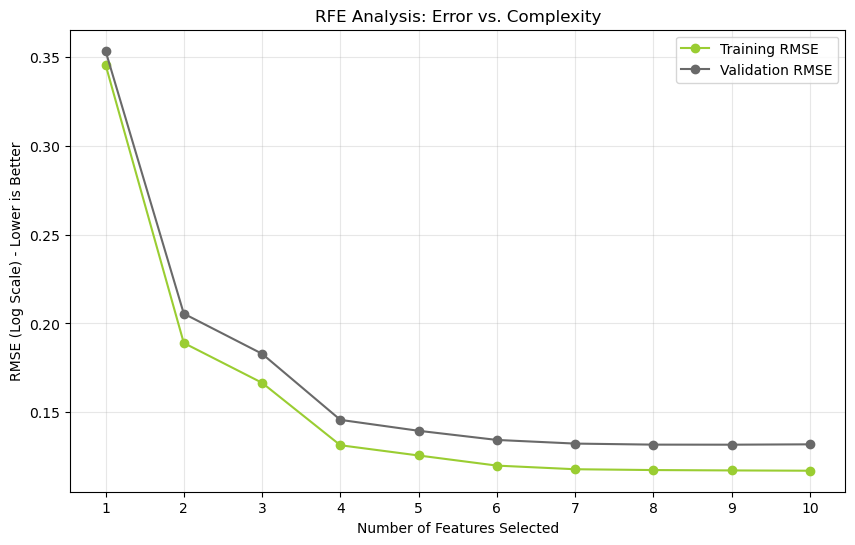

In [8]:
# 1. Prepare Data
# We use your existing 'feature_engineer' and 'preprocessor' to get clean numbers.
# This ensures RFE sees exactly what the final model would see.
X_train_eng = feat_engineer.transform(X_train_clean)
X_train_rfe = preprocessor.fit_transform(X_train_eng, y_train_log)

# Get feature names back from the preprocessor (Tricky but necessary for plotting)
try:
    feature_names = preprocessor.get_feature_names_out()
except:
    # Fallback if names fail
    feature_names = [f"Feature_{i}" for i in range(X_train_rfe.shape[1])]

# 2. Define RFE
# We use a 'Lite' Random Forest (100 trees, Depth 10) to save time.
# n_features_to_select=10: We force it to find the "Top 10" strictly.
rfe_selector = RFE(
    estimator=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=RSEED),
    n_features_to_select=10,
    step=1,  # Remove 1 feature at a time (Most accurate, slowest)
    verbose=1
)

# 3. Execute RFE
rfe_selector.fit(X_train_rfe, y_train_log)

# 4. Extract Results
# We create a clean dataframe to compare RFE Rank vs. Feature Name
rfe_results = pd.DataFrame({
    'Feature': feature_names,
    'Rank': rfe_selector.ranking_,
    'Selected': rfe_selector.support_
}).sort_values('Rank')

# 5. Visualizing the "Top 10"
print("\nTop 10 Features selected by RFE:")
display(rfe_results[rfe_results['Selected'] == True])


# RFE PERFORMANCE VISUALIZATION

# 1. Create a temporary Train/Val split just for this visualization
X_viz_train, X_viz_val, y_viz_train, y_viz_val = train_test_split(
    X_train_rfe, y_train_log, test_size=0.2, random_state=RSEED
)

train_rmse_list = []
val_rmse_list = []
max_features = X_train_rfe.shape[1] # Should be 10

# 2. Loop: Test performance for k=1 to k=10 features
for k in range(1, max_features + 1):
    # Initialize RFE to select 'k' features
    rfe_k = RFE(
        estimator=RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RSEED),
        n_features_to_select=k,
        step=1
    )
    
    # Fit RFE on the training split
    rfe_k.fit(X_viz_train, y_viz_train)
    
    # Transform data (keep only the chosen k columns)
    X_k_train = rfe_k.transform(X_viz_train)
    X_k_val = rfe_k.transform(X_viz_val)
    
    # Train a standard model on this subset of data
    model_k = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RSEED)
    model_k.fit(X_k_train, y_viz_train)
    
    # Calculate RMSE
    # 1. Predict
    pred_train = model_k.predict(X_k_train)
    pred_val = model_k.predict(X_k_val)
    
    # 2. Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_viz_train, pred_train))
    rmse_val = np.sqrt(mean_squared_error(y_viz_val, pred_val))
    
    # 3. Append
    train_rmse_list.append(rmse_train)
    val_rmse_list.append(rmse_val)

# 3. Plotting
x_axis = range(1, len(train_rmse_list) + 1)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, train_rmse_list, label="Training RMSE", color='yellowgreen', marker='o')
plt.plot(x_axis, val_rmse_list, label="Validation RMSE", color='dimgray', marker='o')

plt.xlabel("Number of Features Selected")
plt.ylabel("RMSE (Log Scale) - Lower is Better")
plt.title("RFE Analysis: Error vs. Complexity")
plt.xticks(x_axis)
plt.legend()
plt.grid(True, alpha=0.3)

# Invert Y-axis if you want the curve to go 'up' for good, 
# but for error metrics standard is lower = better (downward slope).
plt.show()

# Embbeded Methods: Random Forest vs Lasso

- Checking Best Feature Selection Method, testing Lasso and Random forest for 10, 7, 6, 5 and 4 features.

### Categorical and Numerical Features Scaled with Robust Scaler

In [9]:
# 1. Global Setup & Data Loading
# ------------------------------------------------------------------------------
RSEED = 42
np.random.seed(RSEED)

# Load data (Assuming train.csv is in current directory)
train_df = pd.read_csv("train.csv")
X_train_full = train_df.drop(columns=['price'])
y_train_log = np.log1p(train_df['price'])

# 2. Define Preprocessing Components
# ------------------------------------------------------------------------------
class CarFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        for col in ['year', 'mileage', 'engineSize']:
            if col in X.columns: X[col] = X[col].astype(float)
        if 'year' in X.columns:
            X['age'] = (2020 - X['year']).clip(lower=0)
        if 'mileage' in X.columns and 'age' in X.columns:
            X['mileage_per_year'] = np.where(X['age'] > 0, X['mileage'] / X['age'], X['mileage'])
            X['mileage_per_year'] = X['mileage_per_year'].replace([np.inf, -np.inf], 0)
        cols_to_drop = ['year', 'paintQuality%', 'previousOwners', 'hasDamage']
        X = X.drop(columns=cols_to_drop, errors='ignore')
        return X

feat_engineer = CarFeatureEngineer()

numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=10, random_state=RSEED)),
    ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', TargetEncoder(target_type='continuous', smooth='auto', random_state=RSEED)),
    ('scaler', RobustScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ],
    remainder='drop'
)

# 3. Define Experiment Parameters
# ------------------------------------------------------------------------------
# We keep the final model constant to judge the quality of the feature set
final_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=RSEED)

# Define the Feature Selectors
selectors = {
    "random forest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RSEED),
    "lasso": Lasso(alpha=0.01, random_state=RSEED)
}

# Define Feature Counts to Test
feature_counts = [10, 7, 6, 5, 4]

# Metrics
scoring = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}

results = []

# 4. Benchmark Loop
# ------------------------------------------------------------------------------
for name, estimator in selectors.items():
    for k in feature_counts:
        # Define RFE for this specific k
        rfe = RFE(estimator=estimator, n_features_to_select=k, step=1)
        
        # Build Pipeline
        pipeline = Pipeline(steps=[
            ('engineer', feat_engineer),
            ('preprocessor', preprocessor),
            ('selector', rfe),
            ('model', final_model)
        ])
        
        # Evaluate
        cv_scores = cross_validate(
            pipeline, 
            X_train_full, 
            y_train_log, 
            cv=5, 
            scoring=scoring,
            n_jobs=-1
        )
        
        # Store Results (Negating error metrics to make them positive)
        results.append({
            'Model Configuration': f"{name} ({k} features)",
            'R^2': cv_scores['test_R2'].mean(),
            'RMSE': -cv_scores['test_RMSE'].mean(),
            'MAE': -cv_scores['test_MAE'].mean()
        })

# 5. Create and Display Table
df_results = pd.DataFrame(results)

# Set the index to match your request structure
df_results.set_index('Model Configuration', inplace=True)

# Display
print("\n" + "="*60)
print("FEATURE SELECTION PERFORMANCE TABLE")
print("="*60)
display(df_results) 


FEATURE SELECTION PERFORMANCE TABLE


,R^2,RMSE,MAE
Model Configuration,,,
random forest (10 features),0.949403,0.119714,0.083935
random forest (7 features),0.948110,0.121248,0.084885
random forest (6 features),0.946083,0.123583,0.086498
random forest (5 features),0.937020,0.133579,0.095057
random forest (4 features),0.929511,0.141306,0.101276
lasso (10 features),0.945353,0.124427,0.087968
lasso (7 features),0.942135,0.128027,0.091054
lasso (6 features),0.941270,0.128993,0.091803
lasso (5 features),0.937020,0.133579,0.095057


### Numerical features scaled with Robust Scaler

In [10]:
# 1. Global Setup & Data Loading
# ------------------------------------------------------------------------------
RSEED = 42
np.random.seed(RSEED)

# Load data (Assuming train.csv is in current directory)
train_df = pd.read_csv("train.csv")
X_train_full = train_df.drop(columns=['price'])
y_train_log = np.log1p(train_df['price'])

# 2. Define Preprocessing Components
# ------------------------------------------------------------------------------
class CarFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        for col in ['year', 'mileage', 'engineSize']:
            if col in X.columns: X[col] = X[col].astype(float)
        if 'year' in X.columns:
            X['age'] = (2020 - X['year']).clip(lower=0)
        if 'mileage' in X.columns and 'age' in X.columns:
            X['mileage_per_year'] = np.where(X['age'] > 0, X['mileage'] / X['age'], X['mileage'])
            X['mileage_per_year'] = X['mileage_per_year'].replace([np.inf, -np.inf], 0)
        cols_to_drop = ['year', 'paintQuality%', 'previousOwners', 'hasDamage']
        X = X.drop(columns=cols_to_drop, errors='ignore')
        return X

feat_engineer = CarFeatureEngineer()

numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, random_state=RSEED)),
    ('scaler', RobustScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', TargetEncoder(target_type='continuous', smooth='auto', random_state=RSEED))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ],
    remainder='drop'
)

# 3. Define Experiment Parameters
# ------------------------------------------------------------------------------
# We keep the final model constant to judge the quality of the feature set
final_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=RSEED)

# Define the Feature Selectors
selectors = {
    "random forest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RSEED),
    "lasso": Lasso(alpha=0.01, random_state=RSEED)
}

# Define Feature Counts to Test
feature_counts = [10, 7, 6, 5, 4]

# Metrics
scoring = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}

results = []

# 4. Benchmark Loop
# ------------------------------------------------------------------------------
for name, estimator in selectors.items():
    for k in feature_counts:
        # Define RFE for this specific k
        rfe = RFE(estimator=estimator, n_features_to_select=k, step=1)
        
        # Build Pipeline
        pipeline = Pipeline(steps=[
            ('engineer', feat_engineer),
            ('preprocessor', preprocessor),
            ('selector', rfe),
            ('model', final_model)
        ])
        
        # Evaluate
        cv_scores = cross_validate(
            pipeline, 
            X_train_full, 
            y_train_log, 
            cv=5, 
            scoring=scoring,
            n_jobs=-1
        )
        
        # Store Results (Negating error metrics to make them positive)
        results.append({
            'Model Configuration': f"{name} ({k} features)",
            'R^2': cv_scores['test_R2'].mean(),
            'RMSE': -cv_scores['test_RMSE'].mean(),
            'MAE': -cv_scores['test_MAE'].mean()
        })

# 5. Create and Display Table
df_results = pd.DataFrame(results)

# Set the index to match your request structure
df_results.set_index('Model Configuration', inplace=True)

# Display
print("\n" + "="*60)
print("FEATURE SELECTION PERFORMANCE TABLE")
print("="*60)
display(df_results) 


FEATURE SELECTION PERFORMANCE TABLE


,R^2,RMSE,MAE
Model Configuration,,,
random forest (10 features),0.949442,0.119666,0.083917
random forest (7 features),0.948114,0.121243,0.084881
random forest (6 features),0.946043,0.123630,0.086497
random forest (5 features),0.936963,0.133641,0.095082
random forest (4 features),0.929536,0.141281,0.101269
lasso (10 features),0.944484,0.125409,0.088977
lasso (7 features),0.940705,0.129618,0.092041
lasso (6 features),0.940345,0.130008,0.092366
lasso (5 features),0.936963,0.133641,0.095082


### Categorical and Numerical Features scaled with Standard Scaler

In [11]:
# 1. Global Setup & Data Loading
# ------------------------------------------------------------------------------
RSEED = 42
np.random.seed(RSEED)

# Load data (Assuming train.csv is in current directory)
train_df = pd.read_csv("train.csv")
X_train_full = train_df.drop(columns=['price'])
y_train_log = np.log1p(train_df['price'])

# 2. Define Preprocessing Components
# ------------------------------------------------------------------------------
class CarFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        for col in ['year', 'mileage', 'engineSize']:
            if col in X.columns: X[col] = X[col].astype(float)
        if 'year' in X.columns:
            X['age'] = (2020 - X['year']).clip(lower=0)
        if 'mileage' in X.columns and 'age' in X.columns:
            X['mileage_per_year'] = np.where(X['age'] > 0, X['mileage'] / X['age'], X['mileage'])
            X['mileage_per_year'] = X['mileage_per_year'].replace([np.inf, -np.inf], 0)
        cols_to_drop = ['year', 'paintQuality%', 'previousOwners', 'hasDamage']
        X = X.drop(columns=cols_to_drop, errors='ignore')
        return X

feat_engineer = CarFeatureEngineer()

numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(max_iter=50, random_state=RSEED)),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', TargetEncoder(target_type='continuous', smooth='auto', random_state=RSEED)),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, make_column_selector(dtype_include=np.number)),
        ('cat', categorical_transformer, make_column_selector(dtype_include=object))
    ],
    remainder='drop'
)

# 3. Define Experiment Parameters
# ------------------------------------------------------------------------------
# We keep the final model constant to judge the quality of the feature set
final_model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=RSEED)

# Define the Feature Selectors
selectors = {
    "random forest": RandomForestRegressor(n_estimators=50, max_depth=10, random_state=RSEED),
    "lasso": Lasso(alpha=0.01, random_state=RSEED)
}

# Define Feature Counts to Test
feature_counts = [10, 7, 6, 5, 4]

# Metrics
scoring = {
    'R2': 'r2',
    'RMSE': 'neg_root_mean_squared_error',
    'MAE': 'neg_mean_absolute_error'
}

results = []

# 4. Benchmark Loop
# ------------------------------------------------------------------------------
for name, estimator in selectors.items():
    for k in feature_counts:
        # Define RFE for this specific k
        rfe = RFE(estimator=estimator, n_features_to_select=k, step=1)
        
        # Build Pipeline
        pipeline = Pipeline(steps=[
            ('engineer', feat_engineer),
            ('preprocessor', preprocessor),
            ('selector', rfe),
            ('model', final_model)
        ])
        
        # Evaluate
        cv_scores = cross_validate(
            pipeline, 
            X_train_full, 
            y_train_log, 
            cv=5, 
            scoring=scoring,
            n_jobs=-1
        )
        
        # Store Results (Negating error metrics to make them positive)
        results.append({
            'Model Configuration': f"{name} ({k} features)",
            'R^2': cv_scores['test_R2'].mean(),
            'RMSE': -cv_scores['test_RMSE'].mean(),
            'MAE': -cv_scores['test_MAE'].mean()
        })

# 5. Create and Display Table
df_results = pd.DataFrame(results)

# Set the index to match your request structure
df_results.set_index('Model Configuration', inplace=True)

# Display
print("\n" + "="*60)
print("FEATURE SELECTION PERFORMANCE TABLE")
print("="*60)
display(df_results) 


FEATURE SELECTION PERFORMANCE TABLE


,R^2,RMSE,MAE
Model Configuration,,,
random forest (10 features),0.949427,0.119685,0.083926
random forest (7 features),0.948106,0.121252,0.084883
random forest (6 features),0.946053,0.123618,0.086492
random forest (5 features),0.936965,0.133638,0.095066
random forest (4 features),0.929550,0.141267,0.101258
lasso (10 features),0.948427,0.120857,0.084911
lasso (7 features),0.941334,0.128920,0.091694
lasso (6 features),0.941257,0.129006,0.091796
lasso (5 features),0.936965,0.133638,0.095066
